In [349]:
import json
import time
import datetime
import os,glob
import sys,re
import spidev
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import hilbert

import pyUn0 as us
%matplotlib inline

# Opening the data and getting RF signals

Data acquired


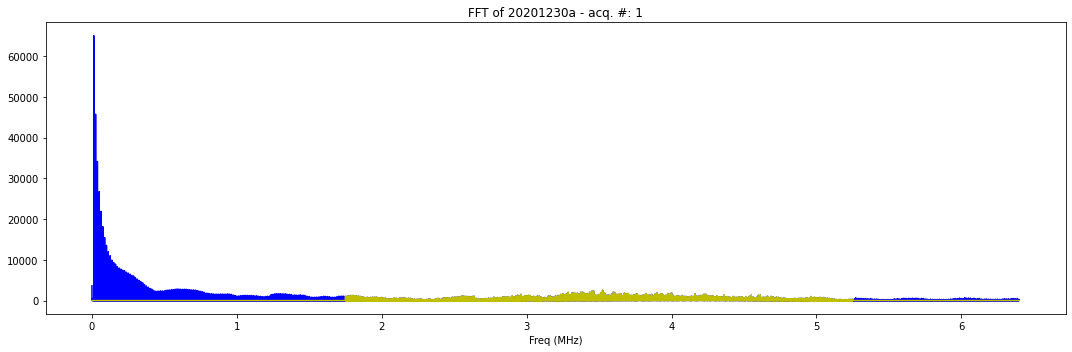

PyExiv not present


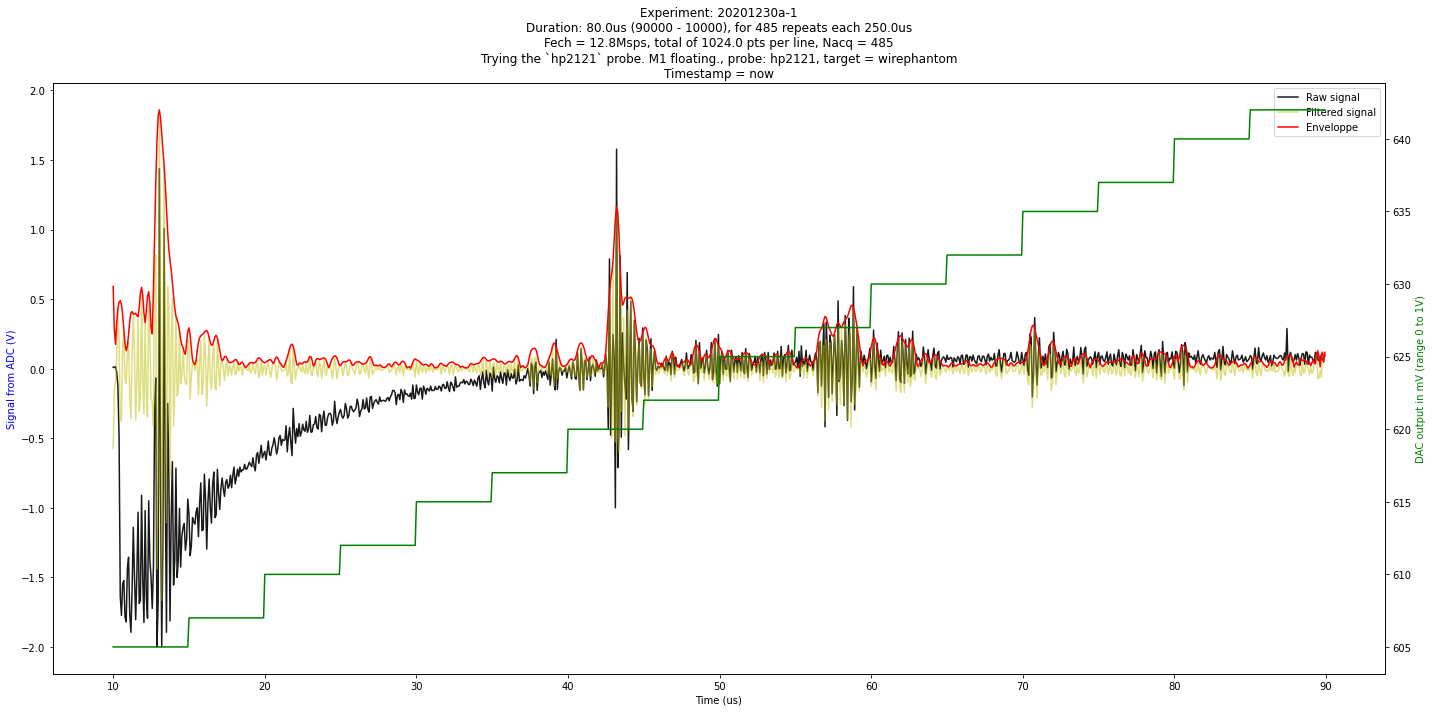

PyExiv not present
1024 485
PyExiv not present


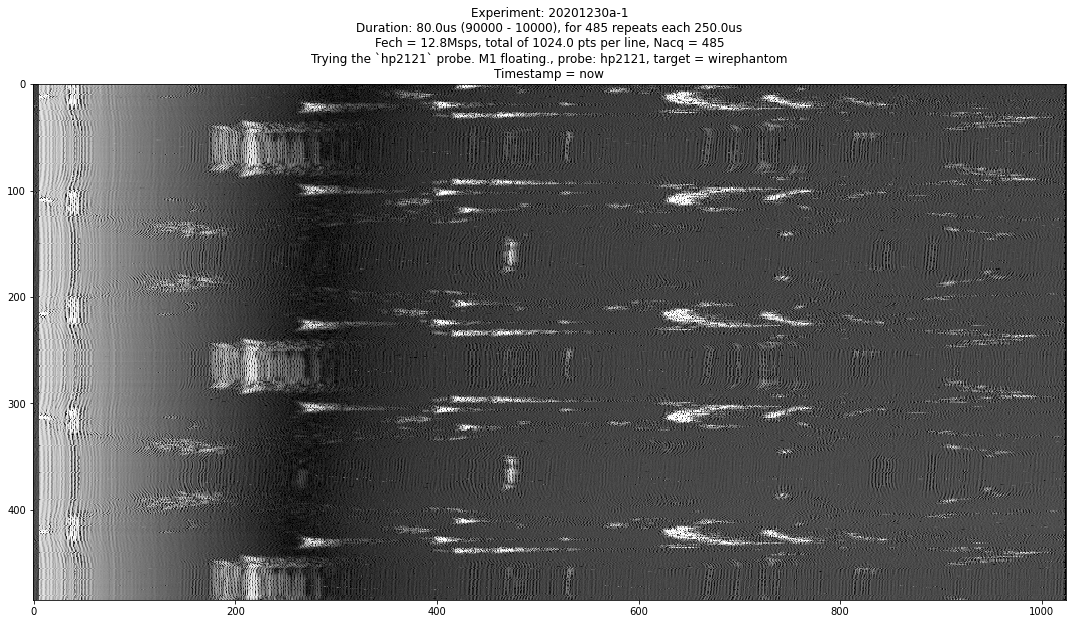

In [350]:
y = us.us_json()
y.JSONprocessing("./data/20201230a-1.json")
y.Bandwidth = 1.0
y.fPiezo = 3.5
y.create_fft() 
y.save_npz() 
y.mkImg() 
twodarray = y.mk2DArray()

# Let's filter the signal.

In [351]:
y.Bandwidth = 0.8 # 80% bandwidth
y.fPiezo = 3.5

original_image = y.raw_2d_image
filtered_image = []
fft_image_filtered = []
num_lines, length_lines = np.shape(original_image)

f_min = (length_lines* y.fPiezo * (1 - y.Bandwidth/2.0) / y.f)
f_max = (length_lines * y.fPiezo * (1 + y.Bandwidth/2.0) / y.f)
                
f_array = [X*y.f / length_lines for X in range(int(length_lines))]

for k in range(int(num_lines)): # number of images
    fft_single_line = np.fft.fft(original_image[k])
    fft_image_filtered.append(fft_single_line)
    for p in range(int(len(fft_single_line)/2+1)): 
        if (p > f_max or p < f_min):
            fft_single_line[p] = 0
            fft_single_line[-p] = 0
    filtered_image.append(np.real(np.fft.ifft(fft_single_line)))

# Getting the raw data

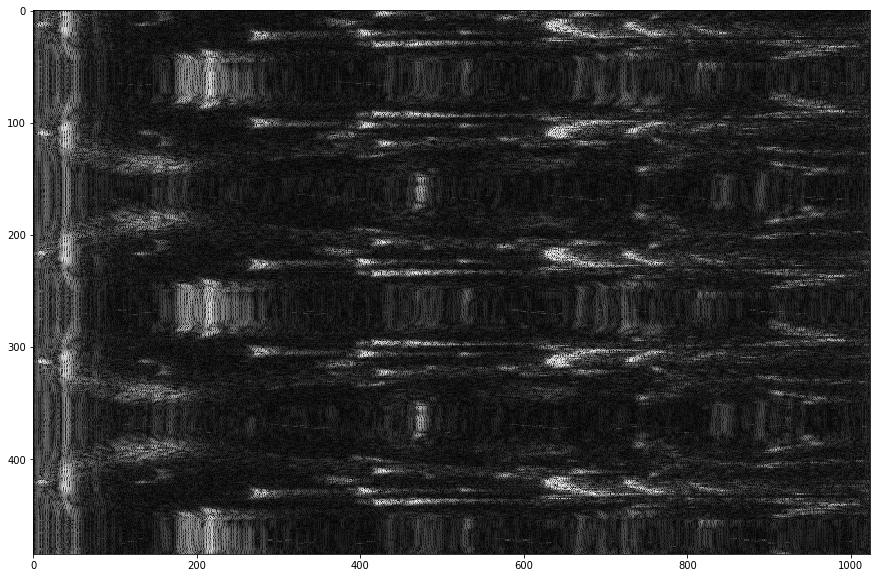

In [352]:
img_size = np.shape(filtered_image) 
plt.figure(figsize = (15,10))
plt.imshow(np.sqrt(np.abs(filtered_image)), cmap='gray', aspect="auto",  interpolation='nearest') #aspect=0.5*(img_size[1]/img_size[0])
plt.savefig("images/set1/rawsignal.png")

# Let's find what are the images frames

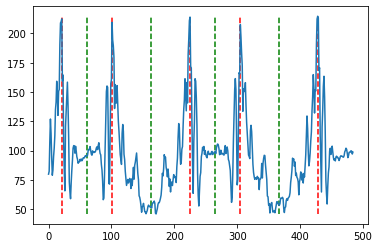

In [353]:
from scipy.signal import argrelextrema
indices = np.sum(np.abs(filtered_image), axis=1)
plt.plot( indices )
GoodPts= []
for x in argrelextrema(indices, np.greater)[0]:
    #print(x,indices[x])
    if indices[x] > 190:
        #print(x,indices[x])
        plt.vlines(x, ymin=np.min(indices),ymax=np.max(indices),colors='r', linestyles='dashed')
        GoodPts.append(x)
Limits = [] 
for x in range(len(GoodPts)):
    if x != 0:
        #print(x)
        plt.vlines((GoodPts[x]+GoodPts[x-1])//2, ymin=np.min(indices),ymax=np.max(indices),colors='g', linestyles='dashed')
        Limits.append( (GoodPts[x]+GoodPts[x-1])//2 )
plt.savefig("images/set1/finding_images.png")

-41


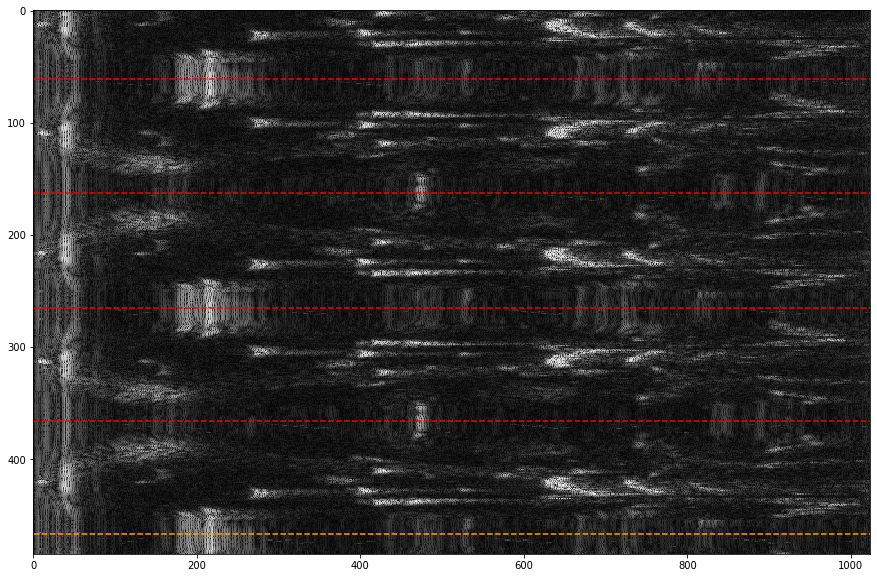

In [354]:
img_size = np.shape(filtered_image) 

plt.figure(figsize = (15,10))
           
plt.imshow(np.sqrt(np.abs(filtered_image)), cmap='gray', aspect="auto",  interpolation='nearest') #aspect=0.5*(img_size[1]/img_size[0])
for lim in Limits:
    plt.hlines(lim, xmin=1,xmax=img_size[1]-1,colors='r', linestyles='dashed')

new = Limits[-1]+Limits[-1]-Limits[-2]
if new < img_size[0]:
    plt.hlines(new, xmin=1,xmax=img_size[1]-1,colors='orange', linestyles='dashed')
    Limits = Limits + [new]
new = Limits[0]-(Limits[1]-Limits[0])
print(new)
if new > 0:
    plt.hlines(new, xmin=1,xmax=img_size[1]-1,colors='orange', linestyles='dashed')
    Limits = [new] + Limits
plt.savefig("images/set1/segmented_signal.png")

# Now that we have the different images, we can extract them

Text(0.5, 1.0, 'Image 4')

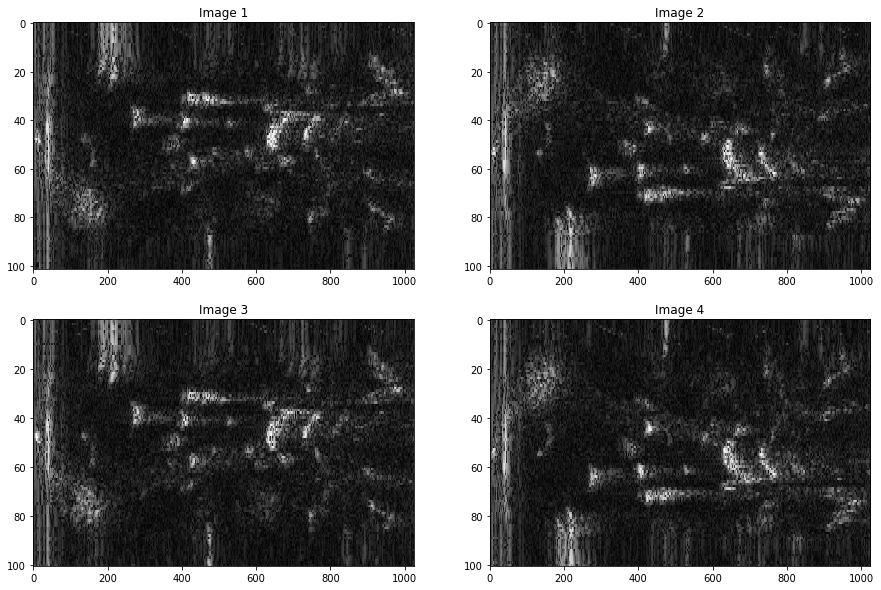

In [355]:
fig, axs = plt.subplots(2, 2,figsize = (15,10))
axs[0, 0].imshow(np.sqrt(np.abs(filtered_image[Limits[0]:Limits[1]])), cmap='gray', aspect="auto",  interpolation='nearest')
axs[0, 0].set_title('Image 1')
axs[0, 1].imshow(np.sqrt(np.abs(filtered_image[Limits[1]:Limits[2]])), cmap='gray', aspect="auto",  interpolation='nearest')
axs[0, 1].set_title('Image 2')
axs[1, 0].imshow(np.sqrt(np.abs(filtered_image[Limits[2]:Limits[3]])), cmap='gray', aspect="auto",  interpolation='nearest')
axs[1, 0].set_title('Image 3')
axs[1, 1].imshow(np.sqrt(np.abs(filtered_image[Limits[3]:Limits[4]])), cmap='gray', aspect="auto",  interpolation='nearest')
axs[1, 1].set_title('Image 4')

# The probe is sweeping, back and forth, so every other image will have a sweeping direction different from its neighbours. We fix that. And take also this to put the probe head to the top of the image.

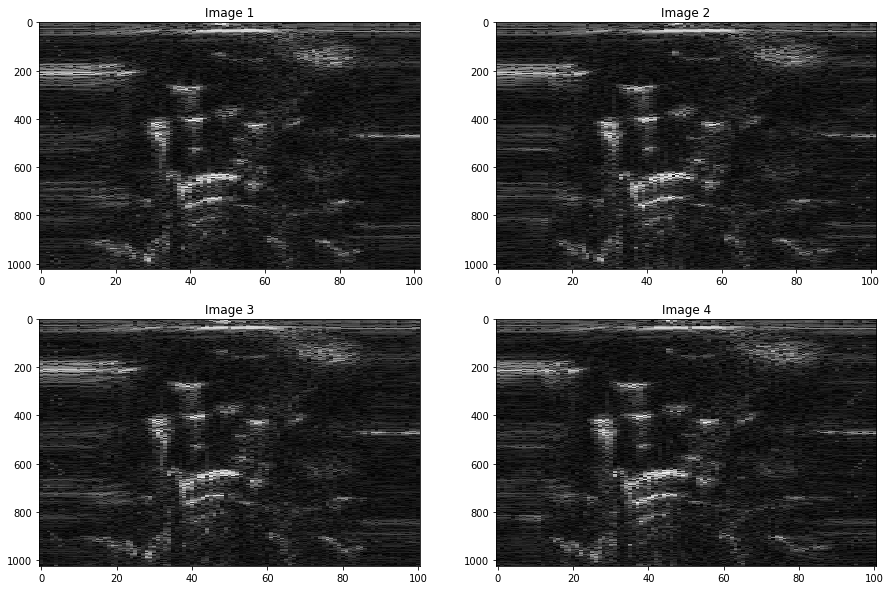

In [356]:
fig, axs = plt.subplots(2, 2,figsize = (15,10))
axs[0, 0].imshow(np.sqrt(np.abs(filtered_image[Limits[0]:Limits[1]])).T, cmap='gray', aspect="auto",  interpolation='nearest')
axs[0, 0].set_title('Image 1')
axs[0, 1].imshow(np.flip(np.sqrt(np.abs(filtered_image[Limits[1]:Limits[2]])),0).T, cmap='gray', aspect="auto",  interpolation='nearest')
axs[0, 1].set_title('Image 2')
axs[1, 0].imshow(np.sqrt(np.abs(filtered_image[Limits[2]:Limits[3]])).T, cmap='gray', aspect="auto",  interpolation='nearest')
axs[1, 0].set_title('Image 3')
axs[1, 1].imshow(np.flip(np.sqrt(np.abs(filtered_image[Limits[3]:Limits[4]])),0).T, cmap='gray', aspect="auto",  interpolation='nearest')
axs[1, 1].set_title('Image 4')
plt.savefig("images/set1/frames.png")

# Resampling to take the probe movement into consideration

In [357]:
mid = np.size(filtered_image[Limits[0]:Limits[1]]) // (2* len(filtered_image[0]))
extend = mid-1
recalc = [ np.cos(np.pi * x / (2.0*extend)) for x in range(mid)]

51 50


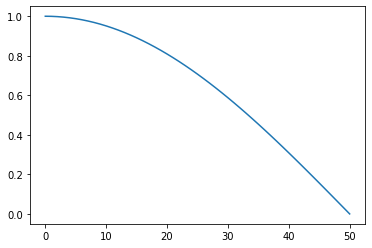

In [358]:
print(mid,extend)
plt.plot(recalc)

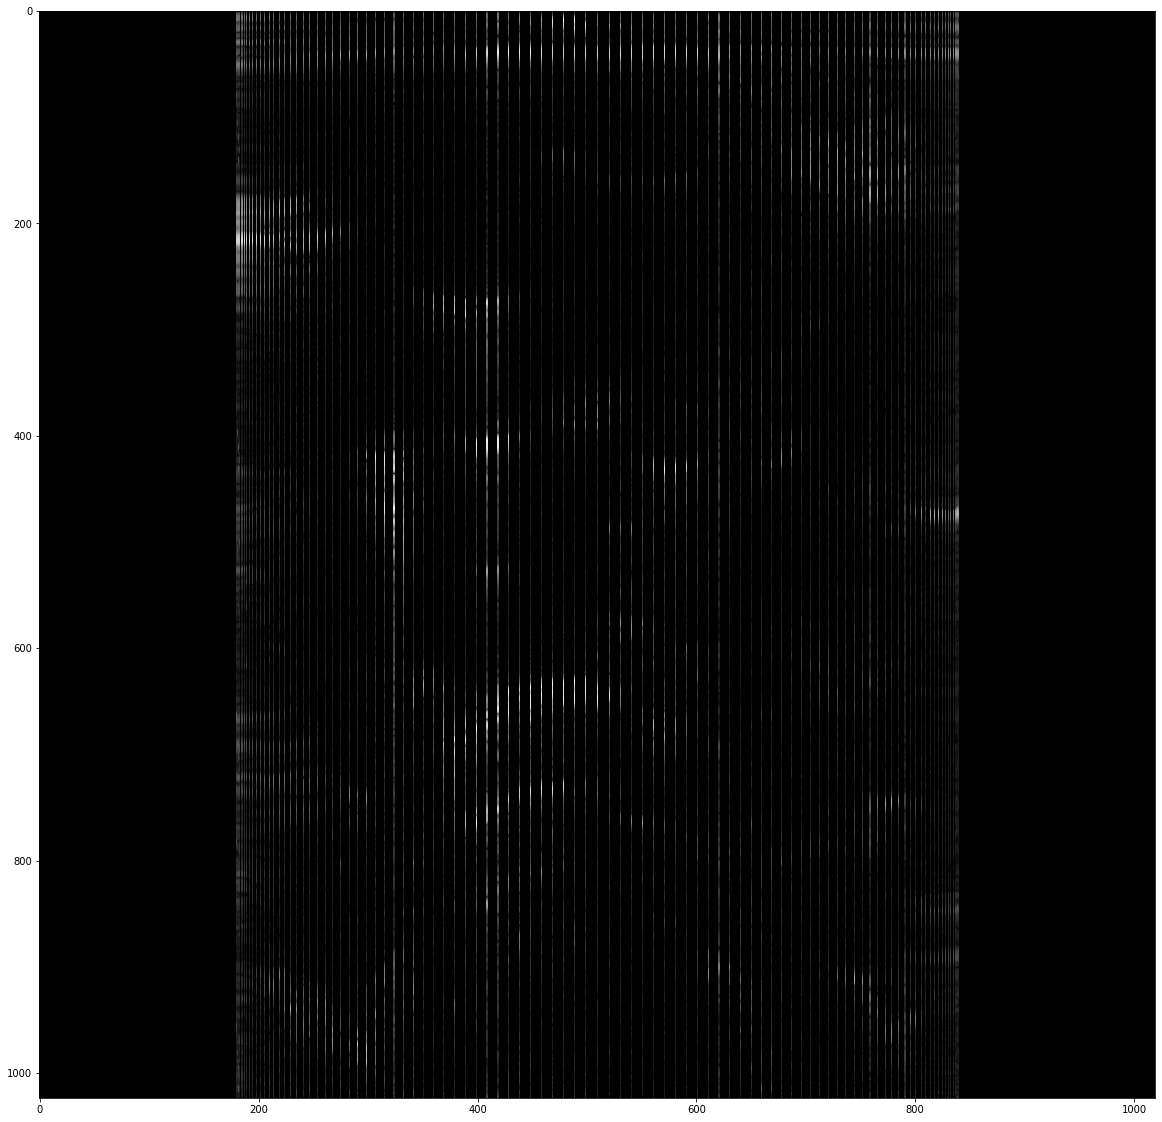

In [359]:
img = np.sqrt(np.abs(hilbert(filtered_image[Limits[0]:Limits[1]])))
plt.figure(figsize = (20,20))
rsmpld = np.zeros((20*mid, len(filtered_image[0])))

step = 10
delta = 0
POINTS = []
VALUES = []
for k in range(extend):
    

    rsmpld[10*mid - delta] = img[mid - k]
    rsmpld[10*mid + delta] = img[mid + k]
    
    for j in range(len(rsmpld[10*mid + delta])):
        POINTS.append((10*mid + delta,j))
        VALUES.append(img[mid + k][j])       
        POINTS.append((10*mid - delta,j))
        VALUES.append(img[mid - k][j])
    delta = int((delta+1.1*step*recalc[k])) 
    Min = 10*mid - delta
    Max = 10*mid + delta
    #print(k,mid-k,mid+k,delta,10*mid - delta,10*mid + delta)
IMG = rsmpld.T
plt.imshow(IMG, cmap='gray', aspect="auto",  interpolation='nearest')

In [360]:
# General use
import numpy as np
import matplotlib.pyplot as plt
# For the scan conversion part
import math
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import decimate, convolve

# Interpolation to recreate the last image, complete

In [361]:
X,Y = np.shape(IMG)
# Creating an empty grid the size of the image
grid_xH, grid_yH = np.mgrid[0:Y:1, 0:X:1]
# Providing the interpolation
grid_z1H = griddata(POINTS, VALUES, (grid_xH, grid_yH), method='linear')

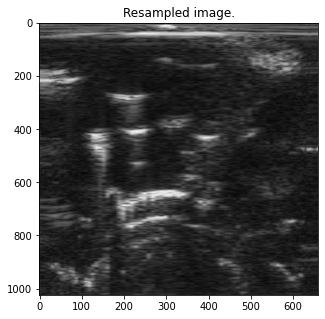

In [362]:
IMGCLEAN = grid_z1H[Min:Max].T
plt.figure(figsize=(5,5))
plt.imshow(IMGCLEAN,cmap=plt.get_cmap('gray'), aspect="auto") 
plt.title("Resampled image.")    
plt.show()

## Comparing before and after resampling

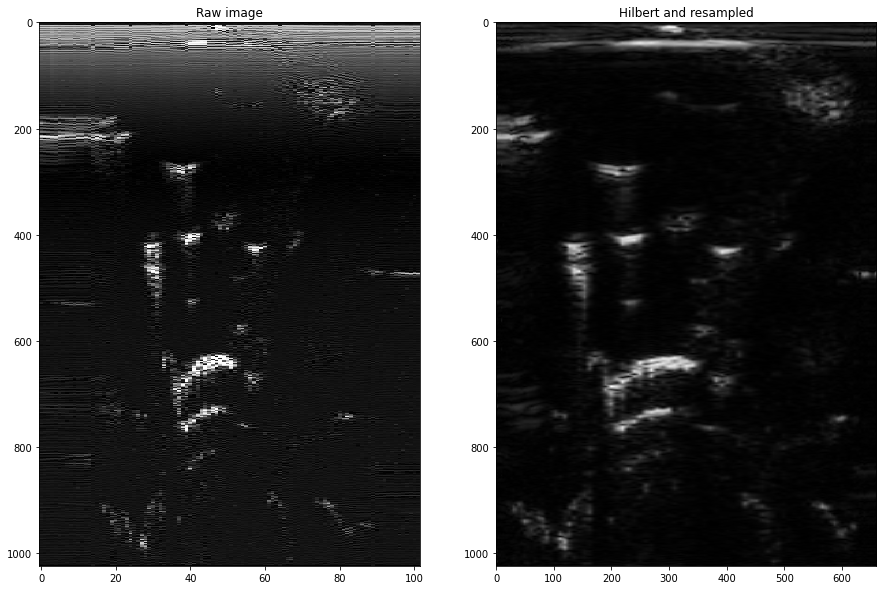

In [363]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize = (15,10))
axs[0].imshow(np.flip((np.abs(original_image[Limits[1]:Limits[2]])),0).T, cmap='gray', aspect="auto",  interpolation='nearest')
axs[0].set_title('Raw image')
axs[1].imshow(IMGCLEAN**2, cmap='gray', aspect="auto",  interpolation='nearest')
axs[1].set_title('Hilbert and resampled')

plt.savefig("images/set1/compare.png")